<a href="https://colab.research.google.com/github/TQT2203/btvn/blob/main/BTVN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow opencv-python matplotlib scikit-learn

In [21]:
from google.colab import files
import zipfile
import os

# Tải file ZIP từ máy lên Colab
uploaded = files.upload()  # Chọn file .zip của bạn

# Giải nén file ZIP
for filename in uploaded.keys():
    zip_path = filename
    extract_folder = filename.replace(".zip", "")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

    print(f"✅ Giải nén hoàn tất vào thư mục: {extract_folder}")

# Kiểm tra thư mục đã giải nén
os.listdir(extract_folder)

Saving dataset.zip to dataset (1).zip
✅ Giải nén hoàn tất vào thư mục: dataset (1)


['dataset_emotion', 'dataset_person']

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os

In [4]:
def load_dataset(dataset_path, img_size):
    data = []
    labels = []
    label_map = {}
    label_id = 0

    # Get a list of all subdirectories (representing classes) in the dataset path
    class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    # Set the number of classes based on the number of subdirectories
    num_classes = len(class_folders)

    for folder in class_folders:  # Iterate through class folders
        folder_path = os.path.join(dataset_path, folder)

        label_map[label_id] = folder.lower()  # Map label ID to folder name

        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(gray, (img_size, img_size))
            data.append(face)
            labels.append(label_id)  # Assign label ID to the image

        label_id += 1  # Move to the next label ID

    X = np.array(data).reshape(-1, img_size, img_size, 1) / 255.0
    y = to_categorical(labels, num_classes=num_classes)  # One-hot encode labels
    return X, y, label_map, num_classes

In [5]:
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')  # Output layer with num_classes neurons
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
IMG_SIZE = 100

print("🚀 Huấn luyện nhận diện người...")
X_p, y_p, label_map_person, num_classes_person = load_dataset("/content/dataset (1)/dataset_person", IMG_SIZE)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

model_person = create_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes_person)
model_person.fit(X_train_p, y_train_p, epochs=100, validation_data=(X_test_p, y_test_p))
model_person.save("model_person.h5")

🚀 Huấn luyện nhận diện người...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3079 - loss: 1.5387 - val_accuracy: 0.4000 - val_loss: 1.2687
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.3183 - loss: 1.2962 - val_accuracy: 0.2000 - val_loss: 1.5020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2789 - loss: 1.4475 - val_accuracy: 0.5000 - val_loss: 1.4527
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.3843 - loss: 1.1845 - val_accuracy: 0.4000 - val_loss: 1.2458
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.5289 - loss: 1.0586 - val_accuracy: 0.7000 - val_loss: 1.0818
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.5868 - loss: 1.0374 - val_accuracy: 0.5000 - val_loss: 1.0509
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7975 - loss: 0.8122 - val_accuracy: 0.6000 - val_loss: 1.0769
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8264 - loss: 0.77

In [28]:
print("\n🚀 Huấn luyện nhận diện cảm xúc...")
X_e, y_e, label_map_emotion, num_classes_emotion = load_dataset("/content/dataset (1)/dataset_emotion", IMG_SIZE)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)

model_emotion = create_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes_emotion)
model_emotion.fit(X_train_e, y_train_e, epochs=60, validation_data=(X_test_e, y_test_e))
model_emotion.save("model_emotion.h5")


🚀 Huấn luyện nhận diện cảm xúc...
Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3871 - loss: 1.1029 - val_accuracy: 0.1250 - val_loss: 2.8000
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step - accuracy: 0.4194 - loss: 1.7563 - val_accuracy: 0.3750 - val_loss: 1.0883
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - accuracy: 0.4194 - loss: 1.4891 - val_accuracy: 0.5000 - val_loss: 1.0149
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.3226 - loss: 1.3570 - val_accuracy: 0.1250 - val_loss: 1.2468
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.6452 - loss: 0.8491 - val_accuracy: 0.1250 - val_loss: 1.4578
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - accuracy: 0.5161 - loss: 0.8786 - val_accuracy: 0.1250 - val_loss: 1.3670
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.5806 - loss: 0.8697 - val_accuracy: 0.3750 - val_loss: 1.2273
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step - accuracy: 0.7097 - loss: 0.8110 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
👉 Đây là THAI và đang cảm thấy HAPPY


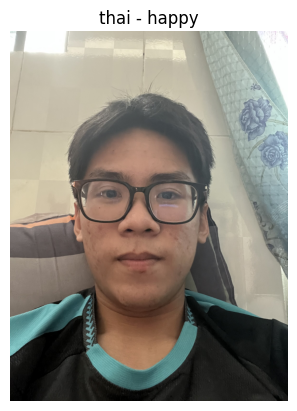

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
👉 Đây là TRUONG và đang cảm thấy SAD


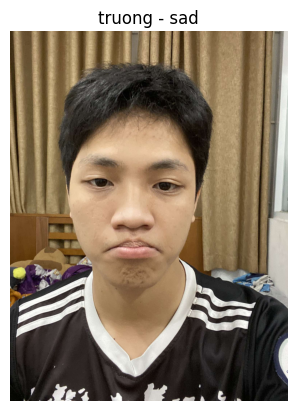

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
👉 Đây là LOC và đang cảm thấy HAPPY


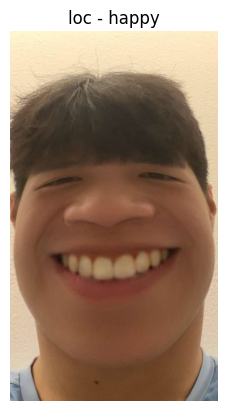

In [29]:
def predict_image(img_path):
   # Add a check if the image is loaded correctly
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image at path: {img_path}")
        return  # Exit the function if image loading fails

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    input_face = face.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    pred_person = model_person.predict(input_face)
    name = label_map_person[np.argmax(pred_person)]

    pred_emotion = model_emotion.predict(input_face)
    emotion = label_map_emotion[np.argmax(pred_emotion)]

    print(f"👉 Đây là {name.upper()} và đang cảm thấy {emotion.upper()}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{name} - {emotion}")
    plt.axis("off")
    plt.show()


predict_image("/content/Thái.jpg")
predict_image("/content/Trường sad.jpg")
predict_image("/content/Lộc smile.jpg")